In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [24]:
#Defining date range for historical analysis
START_DATE = datetime(2020, 1, 1)
END_DATE = datetime(2022, 12, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)
#['2020-04-20']
CRUDE_NEGATIVE_PRICES_DATE = datetime(2020, 4, 20)

#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In [25]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)

    #define the date crude oil prices went negative
    negative_price_date = pd.to_datetime("2020-04-20")

    # Remove the negative price date from floating storage dataset
    df_fs = df_fs[df_fs['date'] != negative_price_date]
    
    return df_fs

In [26]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2020-01-01,145,9016861
1,2020-01-02,139,8437023
2,2020-01-03,141,7750023
3,2020-01-04,134,7886513
4,2020-01-05,139,8568887
...,...,...,...
1091,2022-12-27,171,13097687
1092,2022-12-28,181,13298507
1093,2022-12-29,176,13862553
1094,2022-12-30,172,14031847


Text(0, 0.5, 'Floating Storage (t)')

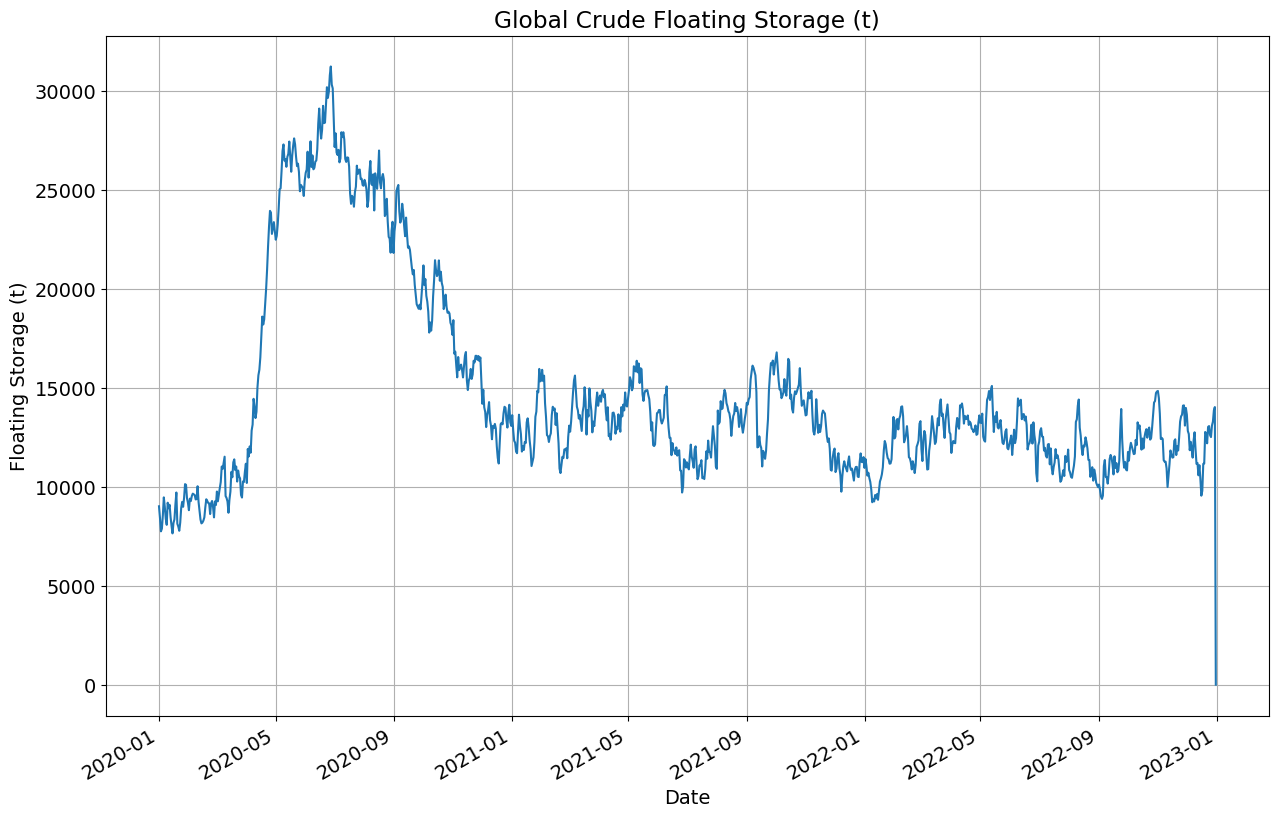

In [27]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

In [37]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
negative_price_date = spot_prices[spot_prices.iloc[:, 0] < 0].index
print(negative_price_date)
spot_prices = spot_prices.drop(negative_price_date)
spot_prices

DatetimeIndex(['2020-04-20'], dtype='datetime64[ns]', freq='D')


,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2020-01-01,61.14,67.77
2020-01-02,61.17,67.05
2020-01-03,63.00,69.08
2020-01-04,63.00,69.08
2020-01-05,63.00,69.08
...,...,...
2022-12-27,79.45,82.45
2022-12-28,78.89,81.70
2022-12-29,78.43,80.96
2022-12-30,80.16,82.82


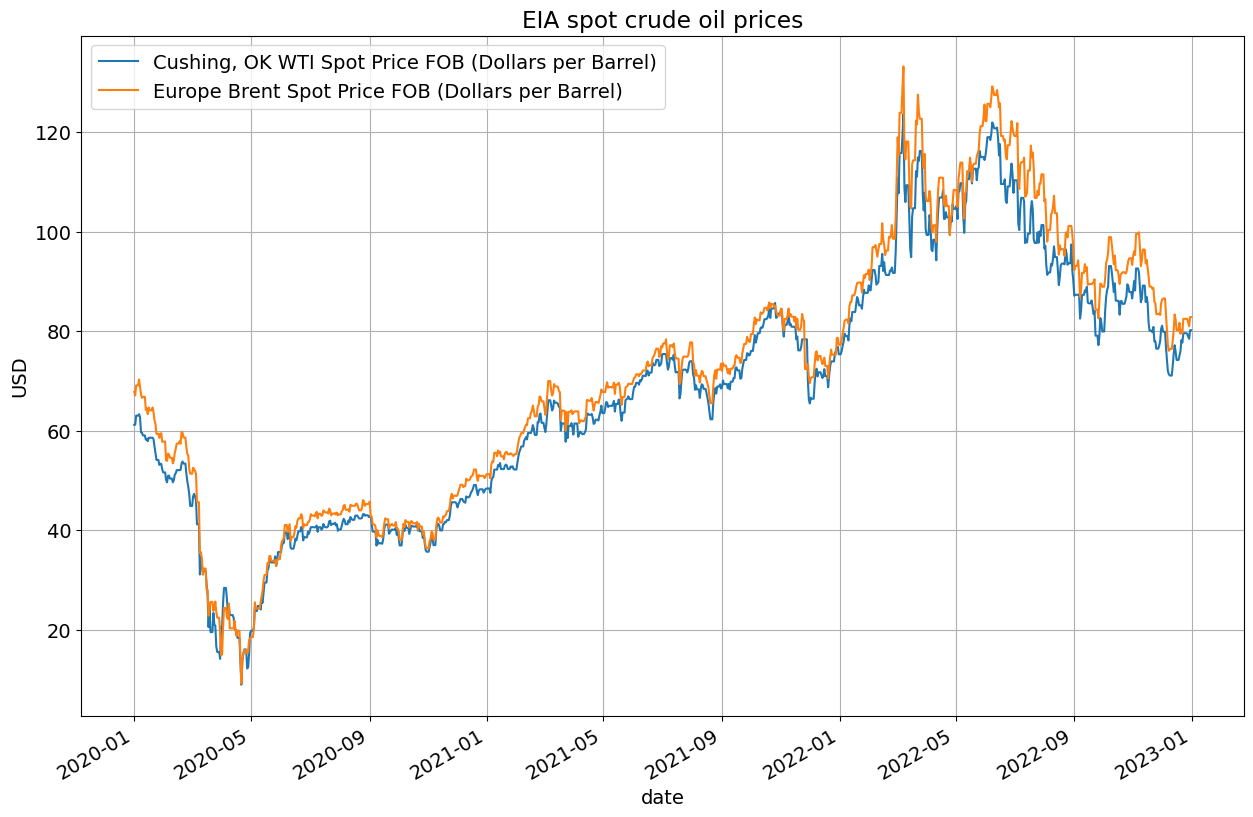

In [33]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');
#removed dates where crude oil prices are negative
